# Think Gaussian Shells with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = \log(e^{f(x,c_1,r_1,w_1)} + e^{f(x,c_2,r_2,w_2)}) $

where $f(x,c,r,w) = -\frac{1}{2 w^2}(|x - c| - r)^2 - \log(\sqrt(2 \pi w^2))$

and

$P(x) = \mathcal{U}[x \mid -6, 6 \pi]$.

## Overview

We'll cover the following topics:

1. How to handle thin curving degeneracies and multimodal behaviour with JAXNS.
2. How to use the `prior_chain` outside the nested sampler, e.g. to sample/plot.
3. How to brute-force compute the evidence for comparison.

In [1]:

import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import jit, vmap
from jax import random, numpy as jnp

from jaxns import ExactNestedSampler
from jaxns import Model
from jaxns import PriorModelGen, Prior
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence
from jaxns import plot_cornerplot, plot_diagnostics
from jaxns import summary
from jaxns.internals.maps import prepare_func_args

tfpd = tfp.distributions

INFO[2022-12-29 03:04:45,522]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-12-29 03:04:45,524]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2022-12-29 03:04:45,524]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2022-12-29 03:04:45,525]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2022-12-29 03:04:45,525]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2022-12-29 03:04:45,526]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:

def log_likelihood(theta):
    def log_circ(theta, c, r, w):
        return -0.5 * (jnp.linalg.norm(theta - c) - r) ** 2 / w ** 2 - jnp.log(jnp.sqrt(2 * jnp.pi * w ** 2))

    w1 = w2 = jnp.array(0.1)
    r1 = r2 = jnp.array(2.)
    c1 = jnp.array([0., -3.])
    c2 = jnp.array([0., 3.])
    return jnp.logaddexp(log_circ(theta, c1, r1, w1), log_circ(theta, c2, r2, w2))


def prior_model() -> PriorModelGen:
    x = yield Prior(tfpd.Uniform(low=-6. * jnp.ones(2), high=6. * jnp.ones(2)), name='theta')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = analytic_log_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")

True log(Z)=-1.7456417083740234


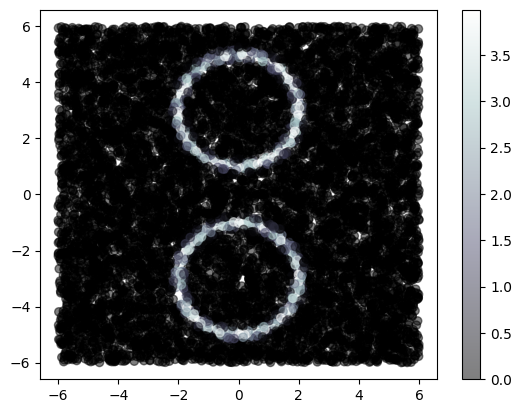

In [3]:
theta = vmap(lambda key: model.transform(model.sample_U(key)))(
    random.split(random.PRNGKey(0), 10000))
# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(lambda theta: prepare_func_args(log_likelihood)(**theta))(theta)
sc = plt.scatter(theta['theta'][:, 0], theta['theta'][:, 1], c=jnp.exp(lik), cmap='bone', alpha=0.5)
plt.colorbar(sc)
plt.show()

In [ ]:


# Create the nested sampler class. In this case without any tuning.
ns = exact_ns = ExactNestedSampler(model=model, num_live_points=100, num_parallel_samplers=1,
                                   max_samples=1000)

termination_reason, state = exact_ns(random.PRNGKey(42),
                                     term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)


In [ ]:
# We can use the summary utility to display results
summary(results)

In [ ]:
# We plot useful diagnostics and a distribution cornerplot
plot_diagnostics(results)
plot_cornerplot(results)